## Setup YOLO and Data For Training

In [ ]:
! unzip -qq YOLOX.zip
! unzip -qq character-detection-datasets.zip

%cd YOLOX

! pip install ninja
! pip install numpy
! pip install opencv_python
! pip install loguru
! pip install tqdm
! pip install thop
! pip install tabulate
! pip install psutil
! pip install tensorboard
! pip install pycocotools
! python setup.py build develop

## Import Libraries for Training and Testing

In [ ]:
import os
from dataclasses import dataclass

from yolox.exp import Exp as MyExp


import argparse
import random
import warnings
from loguru import logger

import torch
import torch.backends.cudnn as cudnn

from yolox.exp import Exp, check_exp_value, get_exp
from yolox.utils import configure_module, configure_nccl, configure_omp, get_num_devices

from yolox.data.data_augment import ValTransform
import cv2
from yolox.utils import postprocess, vis
import time

import matplotlib.pyplot as plt

## Define Model and Training Config

In [ ]:
class Exp(MyExp):
    def __init__(self):
        super(Exp, self).__init__()
        self.depth = 0.33
        self.width = 0.50
        self.exp_name = "Character-Detection"

        self.data_dir = "/content/character-detection-datasets"
        self.train_ann = "train.json"
        self.val_ann = "test.json"

        self.num_classes = 36

        self.max_epoch = 30
        self.eval_interval = 1
        self.data_num_workers = 4

@dataclass
class TrainingConfig:
    experiment_name: str = "CharacterDetection"
    batch_size: int = 16
    resume: bool = False
    ckpt: str = None
    start_epoch: int = 1
    num_machines: int = 1
    machine_rank: int = 0
    fp16: bool = False
    occupy: bool = False
    logger: str = 'tensorboard'
    output_dir = 'checkpoints/'
    cache: str = None

## Load Model and Train

In [ ]:
args = TrainingConfig()
exp = Exp()
trainer = exp.get_trainer(args)
trainer.train()

## Define Predictor for Testing

In [ ]:
class Predictor(object):
    def __init__(
        self,
        model,
        exp,
        cls_names=None,
    ):
        self.model = model
        self.cls_names = cls_names
        self.num_classes = exp.num_classes
        self.confthre = exp.test_conf
        self.nmsthre = exp.nmsthre
        self.test_size = exp.test_size
        self.preproc = ValTransform(legacy=False)
        self.device = "gpu"

    def inference(self, img):
        img_info = {"id": 0}
        if isinstance(img, str):
            img_info["file_name"] = os.path.basename(img)
            img = cv2.imread(img)
        else:
            img_info["file_name"] = None

        height, width = img.shape[:2]
        img_info["height"] = height
        img_info["width"] = width
        img_info["raw_img"] = img

        ratio = min(self.test_size[0] / img.shape[0], self.test_size[1] / img.shape[1])
        img_info["ratio"] = ratio

        img, _ = self.preproc(img, None, self.test_size)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.float()
        if self.device == "gpu":
            img = img.cuda()

        with torch.no_grad():
            t0 = time.time()
            outputs = self.model(img)
            outputs = postprocess(
                outputs, self.num_classes, self.confthre,
                self.nmsthre, class_agnostic=True
            )
            logger.info("Infer time: {:.4f}s".format(time.time() - t0))
        return outputs, img_info

    def visual(self, output, img_info, cls_conf=0.35):
        ratio = img_info["ratio"]
        img = img_info["raw_img"]
        if output is None:
            return img
        output = output.cpu()

        bboxes = output[:, 0:4]

        # preprocessing: resize
        bboxes /= ratio

        cls = output[:, 6]
        scores = output[:, 4] * output[:, 5]

        vis_res = vis(img, bboxes, scores, cls, cls_conf, self.cls_names)
        return vis_res



## Load Trained Model For Inference

In [ ]:
ckpt_file = "/content/YOLOX/YOLOX_outputs/CharacterDetection/epoch_10_ckpt.pth"
model = trainer.model
model.eval()
ckpt = torch.load(ckpt_file, map_location="cpu")
model.load_state_dict(ckpt["model"])

classes = [
        '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
        'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J',
        'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T',
        'U', 'V', 'W', 'X', 'Y', 'Z']

predictor = Predictor(model, exp, classes)


<ipython-input-14-c774e6a0f31c>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_file, map_location="cpu")


## Inference on Image

2025-01-30 17:44:05 | INFO     | __main__:51 - Infer time: 0.0689s


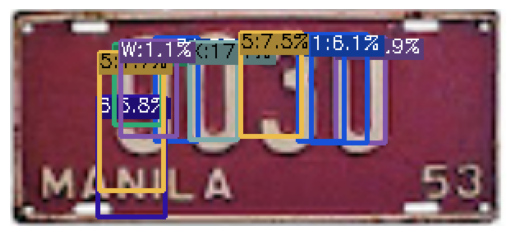

In [ ]:
image_path = "/content/example3.png"
outputs, img_info = predictor.inference(image_path)
result_image = predictor.visual(outputs[0], img_info, predictor.confthre)

plt.figure()
plt.imshow(result_image[..., ::-1])
_ = plt.axis("off")